# Simulating Dickey-Fuller Distribution
## by Ezra van der Stelt

The code in this Jupyter notebook was written using Python 3.7.4. This Jupyter notebook file DFdistribution.ipynb and the results of this simulation study is stored in the public GitHub repository https://github.com/AlbertSteen314/Python-Projects/tree/master/DF.

The goal of this project is to learn more about the theory of unit root econometrics and learn how to conduct a simulation study. In particular I focus on the theory of the dickey-fuller (DF) test of unit roots in an autoregressive model. I derive an approximation of the asymptotic null distribution, critical values for testing, and replicate the power comparisons experiment as is done in the original paper (Dickey & Fuller, 1979).

## Dickey (1976), Dickey & Fuller (1979) papers

For this project I only consider the first order autoregressive data generating model (AR) without deterministic trends 

$$Y_t = \rho Y_{t-1}+\varepsilon_t, t=1,2,..., \tag{1}$$ 

with $Y_0=0$ and i.i.d zero mean constant variance $(\sigma)$ error ${\varepsilon_t}\sim \mathcal{N}(0,\sigma)$. For $|\rho|<1$ the series is known to be stationary, whereas, for $\rho \geqslant 1$ the series is non-stationary and has no defined first and second (unconditional) moments. When $Y_t$ is a random walk, typical inference is not possible, since standard OLS assumptions are violated. The ML and OLS estimator 

$$\hat{\rho} = (Y_{t-1}'Y_{t-1})^{-1}(Y_{t-1}'Y_t) \tag{2}$$ 

will not be student-t distributed like in the stationary case. Many variables are non-stationary so determining whether $\rho=1$ is of interest, to test this the limiting distribution of the test statistic 

$$\hat{\tau}=(\hat{\rho} -1)[((n-k-1)^{-1}S_{\varepsilon}^2)(Y_{t-1}'Y_{t-1})]^{1/2} \tag{3}$$ 

is evaluated. Dickey (1976) derived an approximation of the limiting distribution of $\hat{\tau}$ for different sample sizes $n$. I will also approximate this distribution using the method of Monte Carlo. The number of simulations in Dickey and in this study is 50000. When critical values are obtained I will study the power of the test statistics and its robustness across sample size and differenst magnitudes of autocorrelation. The power of a test relates to the chance of a type two error; in this context it is the tendency to correctly identify the absence of a unit root.   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import time

In [2]:
# set up simulations in order to derive critical values
n = [25, 50, 100, 500, 5000] # sample sizes
N = 50000 # number of simulations
t0 = 0
t_stats = np.zeros((len(n),N))
df_cv = pd.DataFrame(0,index = n, columns = ['0.01', '0.025','0.05','0.10','0.90','0.95', '0.975','0.99'])

In [3]:
def AR(phi , n ,start = 0 ,mu=0 ,sigma=1):
    """
    Generate an AR(1) with coefficient phi of length n starting at start. Innovations have mean
    mu and standard deviation sigma. Default setting is standard gaussian
    innovation at origin. 
    """
    X = np.array([start])
    for i in range(n-1):
        innovation = np.random.normal(mu,sigma)
        X = np.append(X, (p*X[i]+innovation))
    
    return X

In [ ]:
# record N test statistics
start = time.time()
for n_loop,size in enumerate(n):
        for sim in range(N):
            y = AR(phi=1, n=size, start = t0, mu = 0, sigma = 1)
            dy = np.diff(y, n=1)
            ylagged = y[:-1]
            y=y[1:]
            
            beta = (ylagged.T@ylagged)**-1*(ylagged.T@y)
            res = y - beta*ylagged
            se = sqrt((res.T@res/(size-2))/(ylagged.T@ylagged))
            t = (beta-1)/se
            t_stats[n_loop,sim] = t
            
elapsed_time = (time.time() - start)

In [ ]:
elapsed_time
t_stats = t_stats.T
np.save(file = '/Users/ezravanderstelt/Desktop/python/ectri/DF/DFdis.npy', arr = t_stats)
# t_stats = np.load('/Users/ezravanderstelt/Desktop/python/ectri/DF/DFdis.npy')

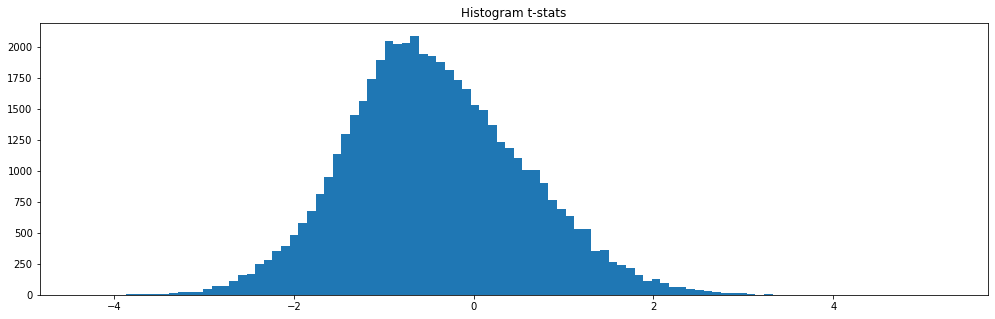

In [5]:
plt.figure(figsize=(17,5))
plt.hist(t_stats[:,4], bins=100)
plt.title('Histogram t-stats')
plt.savefig(fname='/Users/ezravanderstelt/Desktop/python/ectri/DF/DFhist.png')

In [6]:
# construct table that stores critical values test statistic
percentiles = [1, 2.5, 5, 10, 90, 95, 97.5, 99]

for count,size in enumerate(n):
    for col,per in enumerate(percentiles):
        cv = np.percentile(t_stats[:,count],per)
        df_cv.iloc[count,col] = cv    

print(df_cv)
df_cv.to_csv("/Users/ezravanderstelt/Desktop/python/ectri/DF/DFcv.csv")

          0.01     0.025      0.05      0.10      0.90      0.95     0.975  \
25   -2.644563 -2.253873 -1.930973 -1.586596  0.938675  1.353740  1.704179   
50   -2.619271 -2.265221 -1.962579 -1.624238  0.892924  1.304951  1.657107   
100  -2.580644 -2.247675 -1.932284 -1.608289  0.888581  1.298073  1.639735   
500  -2.569170 -2.221221 -1.938655 -1.620569  0.893367  1.292271  1.636211   
5000 -2.568938 -2.242451 -1.951394 -1.621986  0.881086  1.271227  1.612225   

          0.99  
25    2.149836  
50    2.050877  
100   2.027495  
500   2.048720  
5000  2.012007  


In [7]:
# test power
N = 4000 # simulations
phi = [0.8,0.9,0.95,0.99,1,1.02,1.05]
results_twosided = pd.DataFrame(0,index = n, columns = ['0.8', '0.9','0.95',
                                               '0.99','1','1.02', '1.05'])
    
results_tdis = pd.DataFrame(0,index = n, columns = ['0.8', '0.9','0.95',
                                               '0.99','1','1.02', '1.05'])
t_stats_powertest = np.zeros((len(n),N,len(phi)))

In [ ]:
# run new experiments, tau hats of random walks
start = time.time()
for n_loop,size in enumerate(n):
    for phi_loop,p in enumerate(phi):
        for sim in range(N):
            y = AR(phi=p, n=size, start = t0, mu = 0, sigma = 1)
            dy = np.diff(y, n=1)
            ylagged = y[:-1]
            y=y[1:]
            
            beta = (ylagged.T@ylagged)**-1*(ylagged.T@y)
            res = y - beta*ylagged
            se = sqrt((res.T@res/(size-2))/(ylagged.T@ylagged))
            t = (beta-1)/se
            t_stats_powertest[n_loop,sim,phi_loop] = t

elapsed_time = (time.time() - start)
np.save(file = '/Users/ezravanderstelt/Desktop/python/ectri/DF/powerstats.npy', arr = t_stats_powertest)
# t_stats_powertest = np.load('/Users/ezravanderstelt/Desktop/python/ectri/DF/powerstats.npy')

In [9]:
# determine power based on two-sided 5% significance test, contrast with outcome if student-t distribution was assumed
for count,size in enumerate(n):
    for col,p in enumerate(phi):
        critl = df_cv.iloc[count,1] # 0.025
        crith = df_cv.iloc[count,-2] # 0.975
        filt = np.logical_or(t_stats_powertest[count,:,col]<critl,
                             t_stats_powertest[count,:,col]>crith)
        reject = round(np.sum(filt)/t_stats_powertest.shape[1],3)
        results_twosided.iloc[count,col] = reject    
        
t_cv = pd.DataFrame(np.array([[-2.06, 2.06],[-2.01, 2.01],[-1.984,1.984],[-1.96,1.96],[-1.96,1.96]]),
                    index = n, columns = ['0.025','0.975']) # cv different n t-dist

for count,size in enumerate(n):
    for col,p in enumerate(phi):
        critl = t_cv.iloc[count,0]
        crith = t_cv.iloc[count,1]
        filt = np.logical_or(t_stats_powertest[count,:,col]<critl,
                             t_stats_powertest[count,:,col]>crith)
        reject = round(np.sum(filt)/t_stats_powertest.shape[1],3)
        results_tdis.iloc[count,col] = reject    
        
results_twosided.to_csv("/Users/ezravanderstelt/Desktop/python/ectri/DF/powerDF2-test.csv")
results_tdis.to_csv("/Users/ezravanderstelt/Desktop/python/ectri/DF/power-ttest.csv")

In [10]:
results_twosided

,0.8,0.9,0.95,0.99,1,1.02,1.05
25,0.193,0.074,0.041,0.042,0.054,0.100,0.267
50,0.564,0.175,0.072,0.034,0.045,0.217,0.698
100,0.986,0.556,0.178,0.038,0.050,0.557,0.964
500,1.000,1.000,0.999,0.185,0.048,1.000,1.000
5000,1.000,1.000,1.000,1.000,0.055,1.000,1.000


In [11]:
results_tdis

,0.8,0.9,0.95,0.99,1,1.02,1.05
25,0.268,0.110,0.060,0.054,0.052,0.081,0.208
50,0.736,0.282,0.129,0.056,0.053,0.170,0.668
100,0.998,0.743,0.300,0.071,0.059,0.516,0.960
500,1.000,1.000,1.000,0.308,0.060,1.000,1.000
5000,1.000,1.000,1.000,1.000,0.067,1.000,1.000


## Results

The obtained percentiles for the $\tau$ statistic are roughly similar to those in Dickey (1976) (table5.3), almost all values are within a distance of $0.02$. The biggest differences seem to be for the extreme percentiles 0.01 and 0.99.

The power test results are also very similar to those in Dickey/Fuller (1979). Small samples suffer from low power. But the test also seems to have trouble filtering almost unit root processes from unit root processes. The almost unit root and small sample property of a series are complementary in conceiling their 'true' behaviour. Lastly, I examined what would happen were I to proceed as if the test statistic is student-t distributed. It seems to have higher power than the DF test in detecting non-stationarity. However, the test is also biased, as n grows the rejection rate increases past $0.05$. The power of correctly identifying explosive processes rather than unit root processes is lower. 

## Sources:
*  Dickey, David A. (1976), "Estimation and Hypothesis Testing in Nonstationary Time Series," Ph.D. dissertation, Iowa State University.
* Dickey DA, Fuller WA. 1979. Distribution of the estimators for autoregressive time series with a unit root. Journal of the American Statistical Association 74: 427–431.